<a href="https://colab.research.google.com/github/rcout328/Ai-saas/blob/main/scamsafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import datetime

def generate_date():
    return (datetime.datetime.now() - datetime.timedelta(days=random.randint(0, 30))).strftime("%b %d, %Y")

def generate_time():
    return f"{random.randint(1, 12):02d}:{random.randint(0, 59):02d} {'AM' if random.random() < 0.5 else 'PM'}"

def generate_tracking_number():
    return ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', k=10))

def generate_order_number():
    return ''.join(random.choices('0123456789', k=8))

def generate_account_number():
    return ''.join(random.choices('0123456789', k=4))

scam_templates = [
    "URGENT: Your {bank} account ending in {account_number} has been locked. Click here to verify your identity and restore access immediately.",
    "Congratulations! You've won ${amount} in our lottery. To claim your prize, pay a processing fee of ${fee}. Reply 'YES' to proceed.",
    "Your {device} has a VIRUS! Call our Microsoft certified technicians now at 1-800-XXX-XXXX to remove it before your data is stolen.",
    "ALERT: Unauthorized login attempt detected on your {social_media} account. Click this link to secure your account now.",
    "You've been selected for a exclusive job opportunity! Earn ${amount}/week working from home. Small registration fee required. Apply now!",
    "Your {relative} is in trouble and needs ${amount} immediately. Please send money via Western Union to this account: {account_number}.",
    "FINAL NOTICE: Your {utility} bill is overdue. Pay ${amount} now to avoid service disconnection. Click here to make a payment.",
    "Your {delivery_service} package is held at customs. Pay ${amount} in fees to release it. Click here to complete the payment.",
    "Limited time offer: Get 90% off on all {product_category}! Click here to access our exclusive online store. Don't miss out!",
    "Your {bank} credit card has been charged ${amount} for a purchase you didn't make. Call this number immediately to dispute: 1-888-XXX-XXXX"
]

non_scam_templates = [
    "Your {online_store} order #{order_number} has shipped. Track your package here: {tracking_link}",
    "Reminder: Your appointment with Dr. {doctor_name} is tomorrow at {time}. Please arrive 15 minutes early.",
    "Your {bank} account statement for {month} is now available. Log in to your online banking to view.",
    "Thanks for your recent purchase at {store}! Here's a 10% off coupon for your next visit: {coupon_code}",
    "{airline} flight {flight_number} to {destination} is on time. Boarding starts at {time} at Gate {gate}.",
    "Your {subscription_service} subscription will renew on {date}. Update your preferences here: {settings_link}",
    "New message from {sender} on {dating_app}: 'Hi there! I liked your profile. Want to chat?'",
    "Your {food_delivery} order from {restaurant} is on its way. Estimated delivery time: {time}",
    "{gym_name} class reminder: Your {class_type} class starts at {time} tomorrow. Don't forget your water bottle!",
    "Software update available for your {device}. Tap here to install the latest security patches and improvements."
]

banks = ["Chase", "Bank of America", "Wells Fargo", "Citibank", "Capital One"]
devices = ["iPhone", "Android phone", "laptop", "tablet", "smart TV"]
social_media = ["Facebook", "Instagram", "Twitter", "LinkedIn", "TikTok"]
relatives = ["brother", "sister", "cousin", "uncle", "aunt"]
utilities = ["electricity", "water", "gas", "internet", "cable TV"]
delivery_services = ["UPS", "FedEx", "DHL", "USPS", "Amazon Logistics"]
product_categories = ["electronics", "designer clothes", "luxury watches", "skincare products", "supplements"]
online_stores = ["Amazon", "eBay", "Walmart", "Target", "Best Buy"]
airlines = ["Delta", "United", "American Airlines", "Southwest", "JetBlue"]
subscription_services = ["Netflix", "Spotify", "Amazon Prime", "Disney+", "Hulu"]
dating_apps = ["Tinder", "Bumble", "Hinge", "OkCupid", "Match.com"]
food_delivery = ["Uber Eats", "DoorDash", "Grubhub", "Postmates", "Deliveroo"]
gyms = ["LA Fitness", "Planet Fitness", "24 Hour Fitness", "Equinox", "Gold's Gym"]

def generate_scam_message():
    template = random.choice(scam_templates)
    return template.format(
        bank=random.choice(banks),
        account_number=generate_account_number(),
        amount=random.randint(100, 10000),
        fee=random.randint(50, 500),
        device=random.choice(devices),
        social_media=random.choice(social_media),
        relative=random.choice(relatives),
        utility=random.choice(utilities),
        delivery_service=random.choice(delivery_services),
        product_category=random.choice(product_categories)
    )

def generate_non_scam_message():
    template = random.choice(non_scam_templates)
    return template.format(
        online_store=random.choice(online_stores),
        order_number=generate_order_number(),
        tracking_link="https://track.example.com/" + generate_tracking_number(),
        doctor_name=f"Dr. {random.choice(['Smith', 'Johnson', 'Williams', 'Jones', 'Brown'])}",
        time=generate_time(),
        bank=random.choice(banks),
        month=random.choice(["January", "February", "March", "April", "May", "June"]),
        store=random.choice(["Target", "Walmart", "Macy's", "Kohl's", "Home Depot"]),
        coupon_code=''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', k=8)),
        airline=random.choice(airlines),
        flight_number=f"{random.choice(['AA', 'UA', 'DL', 'WN'])}{random.randint(100, 9999)}",
        destination=random.choice(["New York", "Los Angeles", "Chicago", "Miami", "San Francisco"]),
        gate=f"{random.choice('ABCDE')}{random.randint(1, 50)}",
        subscription_service=random.choice(subscription_services),
        date=generate_date(),
        settings_link="https://settings.example.com/" + ''.join(random.choices('abcdefghijklmnopqrstuvwxyz0123456789', k=10)),
        sender=random.choice(["Alex", "Sam", "Jordan", "Taylor", "Casey"]),
        dating_app=random.choice(dating_apps),
        food_delivery=random.choice(food_delivery),
        restaurant=random.choice(["Pizza Hut", "McDonald's", "Subway", "Chipotle", "Burger King"]),
        gym_name=random.choice(gyms),
        class_type=random.choice(["yoga", "spin", "HIIT", "pilates", "zumba"]),
        device=random.choice(devices)
    )

messages = []
for _ in range(300):
    if random.random() < 0.3:  # 30% chance of scam message
        messages.append(generate_scam_message())
    else:
        messages.append(generate_non_scam_message())

# Output messages in list format
print("messages = [")
for message in messages:
    print(f"    \"{message}\",")
print("]")

print(f"\nTotal messages generated: {len(messages)}")

messages = [
    "Your Wells Fargo account statement for May is now available. Log in to your online banking to view.",
    "Reminder: Your appointment with Dr. Dr. Jones is tomorrow at 02:11 PM. Please arrive 15 minutes early.",
    "Your tablet has a VIRUS! Call our Microsoft certified technicians now at 1-800-XXX-XXXX to remove it before your data is stolen.",
    "Your Hulu subscription will renew on Jul 03, 2024. Update your preferences here: https://settings.example.com/i3a3suc9gv",
    "Your brother is in trouble and needs $4283 immediately. Please send money via Western Union to this account: 0962.",
    "Your Spotify subscription will renew on Jul 07, 2024. Update your preferences here: https://settings.example.com/qiekxyebkr",
    "Reminder: Your appointment with Dr. Dr. Williams is tomorrow at 04:13 PM. Please arrive 15 minutes early.",
    "Your Bank of America account statement for January is now available. Log in to your online banking to view.",
    "JetBlue flight AA413

In [ ]:
!pip install torchtext

Epoch [1/50], Loss: 0.4054, Val Loss: 0.5413
Epoch [2/50], Loss: 0.2332, Val Loss: 0.5227
Epoch [3/50], Loss: 0.4474, Val Loss: 0.5286
Epoch [4/50], Loss: 0.4336, Val Loss: 0.5348
Epoch [5/50], Loss: 0.4751, Val Loss: 0.5417
Epoch [6/50], Loss: 0.5155, Val Loss: 0.5629
Epoch [7/50], Loss: 0.3613, Val Loss: 0.5551
Early stopping triggered


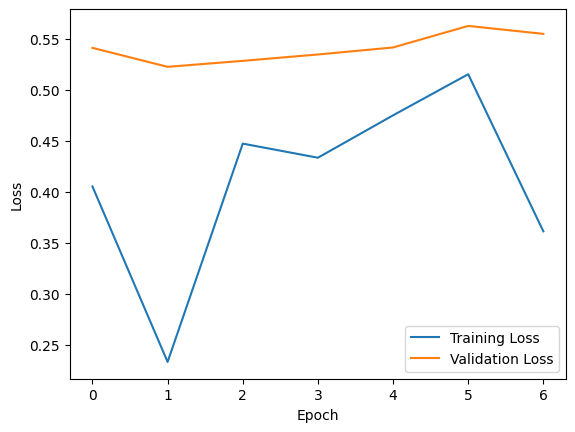

Accuracy: 0.7270
Message: Start earning $5000 a week from the comfort of your home. Sign up now!
Predicted result: scam

Message: Invest in this exclusive opportunity and double your money in a month!
Predicted result: scam

Message: Unlock the secret to making thousands of dollars online with minimal effort.
Predicted result: ham

Message: Join our investment group and see returns like never before!
Predicted result: ham

Message: Make a six-figure income working part-time. Learn how!
Predicted result: ham

Message: Discover the easiest way to get rich quick. Click here!
Predicted result: scam

Message: Turn your savings into a fortune with our investment plan.
Predicted result: ham

Message: Earn passive income effortlessly. Register today!
Predicted result: scam

Message: Be your own boss and make money fast. Start now!
Predicted result: scam

Message: Exclusive offer: triple your earnings in just weeks!
Predicted result: scam

Message: Congratulations! You've won a $1000 gift card.

In [ ]:
: {message}\nPredicted result: {result}\n')

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2

Epoch [1/10], Loss: 0.3381
Epoch [3/10], Loss: 0.2384
Epoch [5/10], Loss: 0.1979
Epoch [7/10], Loss: 0.0368
Epoch [9/10], Loss: 0.0198


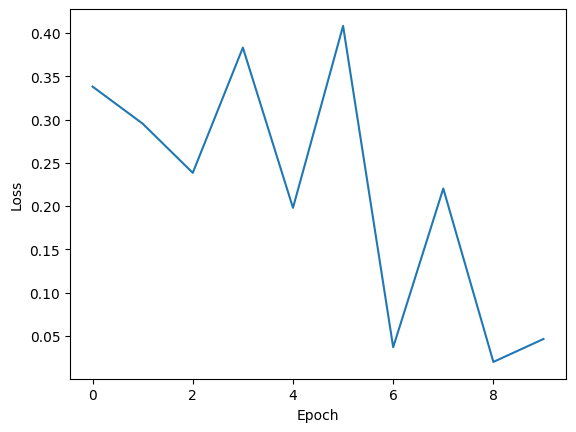

Accuracy: 0.8289
Message: अरे, आप कैसे हैं?
Predicted result: ham

Message: रिमाइंडर: आपकी दंत चिकित्सक से मुलाकात कल दोपहर 2 बजे है।
Predicted result: ham

Message: बस यह देखने के लिए जाँच कर रहा हूँ कि आपको रिपोर्ट मिली या नहीं।
Predicted result: ham

Message: कल सुबह 10 बजे मीटिंग की पुष्टि हुई है।
Predicted result: ham

Message: घर जाते समय दूध लेना न भूलें।
Predicted result: ham

Message: सप्ताहांत के लिए मौसम बहुत अच्छा लग रहा है! आनंद लें!
Predicted result: ham

Message: आज की मीटिंग के नोट्स यहाँ हैं।
Predicted result: ham

Message: मैं आज घर से काम करूँगा।
Predicted result: ham

Message: प्रोजेक्ट में आपकी मदद के लिए धन्यवाद!
Predicted result: ham

Message: आपकी पदोन्नति पर बधाई!
Predicted result: ham



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam4.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size=20, h1=128, h2=62, out_features=1):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10
losses = []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    if epoch % 2 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the training loss
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results

new_messages = [
 "अरे, आप कैसे हैं?",

"रिमाइंडर: आपकी दंत चिकित्सक से मुलाकात कल दोपहर 2 बजे है।",

"बस यह देखने के लिए जाँच कर रहा हूँ कि आपको रिपोर्ट मिली या नहीं।",

"कल सुबह 10 बजे मीटिंग की पुष्टि हुई है।",

"घर जाते समय दूध लेना न भूलें।",

"सप्ताहांत के लिए मौसम बहुत अच्छा लग रहा है! आनंद लें!",

"आज की मीटिंग के नोट्स यहाँ हैं।",

"मैं आज घर से काम करूँगा।",

"प्रोजेक्ट में आपकी मदद के लिए धन्यवाद!",

"आपकी पदोन्नति पर बधाई!",
]


# Get predictions for multiple messages
results = check_multiple_messages(model, new_messages, vectorizer)

# Print the results
for message, result in results:
    print(f'Message: {message}\nPredicted result: {result}\n')

In [ ]:
torch.save(model.state_dict(), 'scam.pth')

Epoch [1/100], Loss: 0.5996, Val Loss: 0.5709
Epoch [2/100], Loss: 0.3891, Val Loss: 0.5236
Epoch [3/100], Loss: 0.7959, Val Loss: 0.5091
Epoch [4/100], Loss: 0.5729, Val Loss: 0.5083
Epoch [5/100], Loss: 1.1443, Val Loss: 0.5212
Epoch [6/100], Loss: 0.8427, Val Loss: 0.5308
Epoch [7/100], Loss: 1.2651, Val Loss: 0.5331
Epoch [8/100], Loss: 0.2232, Val Loss: 0.5429
Epoch [9/100], Loss: 0.2178, Val Loss: 0.5442
Early stopping triggered


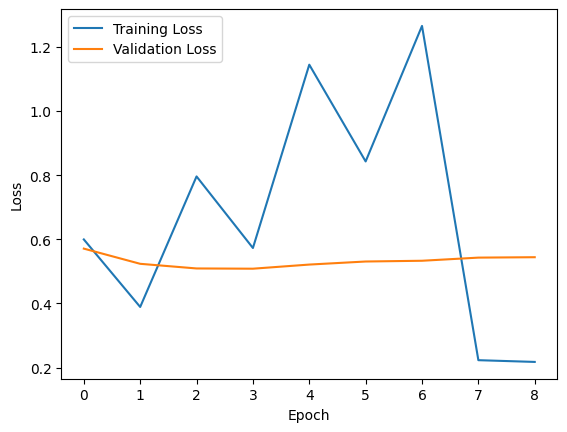

Accuracy: 0.7280
Message: You've won a $1,000 gift card! Click here to claim your prize.
Predicted result: scam

Message: Congratulations! You've been selected for a free cruise. Call now to book your trip.
Predicted result: scam

Message: Your account has been compromised. Please click this link to secure your account.
Predicted result: scam

Message: Earn $5,000 a week working from home! Sign up now.
Predicted result: scam

Message: Invest in our exclusive scheme and double your money in a month!
Predicted result: scam

Message: Your bank account will be locked unless you verify your details here.
Predicted result: scam

Message: Urgent: Your payment is pending. Click to complete the transaction.
Predicted result: scam

Message: You've received a tax refund. Click here to claim it now.
Predicted result: scam

Message: Get a loan approved instantly with no credit check. Apply here.
Predicted result: ham

Message: Your package is waiting for delivery. Confirm your address now.
Predicte

In [15]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam6.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.out = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 100
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()  # Update the learning rate

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).squeeze()
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results

    new_messages = [
     # Ham Messages
    "अरे, आप कैसे हैं?",

"रिमाइंडर: आपकी दंत चिकित्सक से मुलाकात कल दोपहर 2 बजे है।",

"बस यह देखने के लिए जाँच कर रहा हूँ कि आपको रिपोर्ट मिली या नहीं।",

"कल सुबह 10 बजे मीटिंग की पुष्टि हुई है।",

"घर जाते समय दूध लेना न भूलें।",

"सप्ताहांत के लिए मौसम बहुत अच्छा लग रहा है! आनंद लें!",

"आज की मीटिंग के नोट्स यहाँ हैं।",

"मैं आज घर से काम करूँगा।",

"प्रोजेक्ट में आपकी मदद के लिए धन्यवाद!",

"आपकी पदोन्नति पर बधाई!",
]

for message, result in results:
    print(f'Message: {message}\nPredicted result: {result}\n')

Epoch [1/50], Loss: 0.6729, Val Loss: 0.5652
Epoch [2/50], Loss: 0.3047, Val Loss: 0.5171
Epoch [3/50], Loss: 0.4945, Val Loss: 0.5168
Epoch [4/50], Loss: 0.3681, Val Loss: 0.5143
Epoch [5/50], Loss: 0.5101, Val Loss: 0.5436
Epoch [6/50], Loss: 0.3680, Val Loss: 0.5577
Epoch [7/50], Loss: 0.6890, Val Loss: 0.6105
Epoch [8/50], Loss: 0.2788, Val Loss: 0.6373
Epoch [9/50], Loss: 0.0900, Val Loss: 0.6462
Early stopping triggered


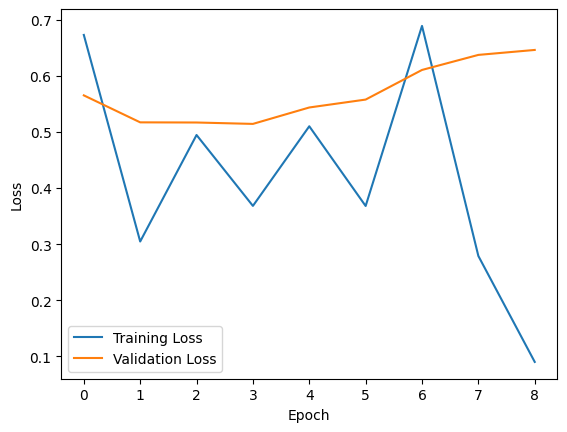

Accuracy: 0.7224
Message: Hey, how are you doing?
Predicted result: ham

Message: Reminder: Your dentist appointment is tomorrow at 2 PM.
Predicted result: ham

Message: Just checking in to see if you got the report.
Predicted result: ham

Message: Meeting confirmed for 10 AM tomorrow.
Predicted result: ham

Message: Don't forget to pick up milk on your way home.
Predicted result: ham

Message: The weather looks great for the weekend! Enjoy!
Predicted result: ham

Message: Here are the notes from today's meeting.
Predicted result: ham

Message: I'll be working from home today.
Predicted result: ham

Message: Thanks for your help with the project!
Predicted result: ham

Message: Congratulations on your promotion!
Predicted result: ham

Message: You've won a free vacation! Claim now with this link.
Predicted result: scam

Message: Your account needs verification. Please click here to proceed.
Predicted result: scam

Message: Congratulations! You've been selected for a cash prize.
Predict

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam6.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Increased batch size

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Increased learning rate

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 50  # Increased epochs
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).squeeze()
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results


    new_messages = [
 # Ham Messages
  "अरे, आप कैसे हैं?",

"रिमाइंडर: आपकी दंत चिकित्सक से मुलाकात कल दोपहर 2 बजे है।",

"बस यह देखने के लिए जाँच कर रहा हूँ कि आपको रिपोर्ट मिली या नहीं।",

"कल सुबह 10 बजे मीटिंग की पुष्टि हुई है।",

"घर जाते समय दूध लेना न भूलें।",

"सप्ताहांत के लिए मौसम बहुत अच्छा लग रहा है! आनंद लें!",

"आज की मीटिंग के नोट्स यहाँ हैं।",

"मैं आज घर से काम करूँगा।",

"प्रोजेक्ट में आपकी मदद के लिए धन्यवाद!",

"आपकी पदोन्नति पर बधाई!",
]
# Get predictions for multiple messages
results = check_multiple_messages(model, new_messages, vectorizer)

# Print the results
for message, result in results:
    print(f'Message: {message}\nPredicted result: {result}\n')

In [ ]:
model.load_state_dict(torch.load('scam.pth'))
model.eval()

In [ ]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
import pickle

# Define your neural network model class
class SMSNet(nn.Module):
    def __init__(self, input_size=6000, h1=62, h2=62, h3=62 ,h4=62 ,h5=62 out_features=1):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

# Define the message input model
class MessageInput(BaseModel):
    messages: List[str]

# Initialize FastAPI
app = FastAPI()

# Load your trained model
model_path = 'scam.pth'  # Update with your model path
new_model = SMSNet(input_size=6000)
new_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
new_model.eval()

# Load vectorizer
vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

# Function to preprocess a single message
def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

@app.post("/predict")
async def predict(input: MessageInput):
    messages = input.messages
    results = []

    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = new_model(message_tensor)
        result = 'scam' if prediction.item() > 0.5 else 'ham'
        results.append(result)

    return {"results": results}

# For testing connection
@app.get("/")
async def read_root():
    return {"message": "API is working"}

if __name__ == '__main__':
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [ ]:
import requests

url = 'http://localhost:5000/predict'
data = {'your': 'input data'}  # Replace with your actual input data
response = requests.post(url, json=data)
print(response.json())


In [ ]:
!pip install flask-ngrok

from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json  # Assuming the input data is sent as JSON
    input_tensor = preprocess(data)  # Preprocess the input data to the required format
    with torch.no_grad():
        output = model(input_tensor)
    prediction = postprocess(output)  # Convert the model output to a human-readable format
    return jsonify(prediction)

def preprocess(data):
    # Add your preprocessing logic here
    # Convert the input data to a tensor, etc.
    return input_tensor

def postprocess(output):
    # Add your postprocessing logic here
    # Convert the model output to a JSON-serializable format
    return prediction

if __name__ == '__main__':
    app.run()


In [ ]:
!pip install --quiet --upgrade google-cloud-storage
!pip install --quiet --upgrade google-cloud-sdk
from google.colab import auth
auth.authenticate_user()
!gcloud services enable run.googleapis.com
!gcloud services enable containerregistry.googleapis.com
!gcloud services enable cloudbuild.googleapis.com

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torchtext.legacy.data.utils import get_tokenizer
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam6.csv', encoding='utf-8')

# Preprocess text data
data['v2'].fillna('', inplace=True)
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = get_tokenizer('basic_english')

# Define fields
TEXT = Field(tokenize=tokenizer, lower=True, include_lengths=True, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False, is_target=True)

# Convert pandas DataFrame to csv for TabularDataset
data.to_csv('data.csv', index=False)

# Create TabularDataset
fields = [('v1', LABEL), ('v2', TEXT)]
dataset = TabularDataset(path='data.csv', format='csv', fields=fields, skip_header=True)

# Split dataset
train_data, test_data = dataset.split(split_ratio=0.8, random_state=torch.Generator().manual_seed(42))

# Build vocabulary
TEXT.build_vocab(train_data, max_size=5000)

# Create iterators
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=64,
    sort_within_batch=True,
    sort_key=lambda x: len(x.v2),
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# Model parameters
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

# Instantiate the model
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

# Set the criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 50
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for batch in train_iterator:
        text, text_lengths = batch.v2
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.v1.float())
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in test_iterator:
            text, text_lengths = batch.v2
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.v1.float())
            val_loss += loss.item()

    val_loss /= len(test_iterator)
    val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = []
    labels = []
    for batch in test_iterator:
        text, text_lengths = batch.v2
        predictions = model(text, text_lengths).squeeze(1)
        outputs.append(predictions)
        labels.append(batch.v1.float())

    outputs = torch.cat(outputs)
    labels = torch.cat(labels)
    predicted = (torch.sigmoid(outputs) > 0.5).float()
    accuracy = (predicted == labels).sum().item() / labels.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

# Prediction functions
def preprocess_message(message, TEXT):
    tokenizer = get_tokenizer('basic_english')
    tokens = tokenizer(f"System: This message needs to be classified as scam or ham. Message: {message}")
    tokenized = [TEXT.vocab.stoi[t] for t in tokens]
    message_tensor = torch.tensor([tokenized], dtype=torch.long)
    message_length = torch.tensor([len(tokenized)])
    return message_tensor, message_length

def predict_message(model, message_tensor, message_length):
    model.eval()
    with torch.no_grad():
        output = model(message_tensor, message_length)
        prediction = torch.sigmoid(output).item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction > 0.5 else 'ham'

def check_multiple_messages(model, messages, TEXT):
    results = []
    for message in messages:
        message_tensor, message_length = preprocess_message(message, TEXT)
        prediction = predict_message(model, message_tensor, message_length)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results

# Example new messages for testing
new_messages = [
    "आपको सप्ताह में $5000 कमाने का मौका। अभी साइन अप करें!",
    "इस विशेष अवसर में निवेश करें और एक महीने में अपना पैसा दोगुना करें!",
    "ऑनलाइन हजारों डॉलर कमाने का राज जानें। क्लिक करें!",
    "हमारे निवेश समूह में शामिल हों और अप्रत्याशित लाभ प्राप्त करें!",
    "अंशकालिक काम करके छः अंकों की आय कमाएं। जानें कैसे!",
    "जल्दी अमीर बनने का सबसे आसान तरीका जानें। यहाँ क्लिक करें!",
    "हमारे निवेश योजना के साथ अपनी बचत को एक संपत्ति में बदलें।",
    "बिना किसी प्रयास के निष्क्रिय आय कमाएं। आज ही पंजीकरण करें!",
    "अपना खुद का बॉस बनें और तेजी से पैसा कमाएं। अभी शुरू करें!",
    "विशेष प्रस्ताव: अपने कमाई को हफ्तों में तीन गुना करें!"
]

results = check_multiple_messages(model, new_messages, TEXT)

# Print the results
for message, result in results:
    print(f'Message: {message}\nPredicted result: {result}\n')

ModuleNotFoundError: No module named 'torchtext.legacy'

Epoch [1/50], Loss: 0.6336, Val Loss: 0.5055
Epoch [2/50], Loss: 0.5328, Val Loss: 0.4524
Epoch [3/50], Loss: 0.5036, Val Loss: 0.4480
Epoch [4/50], Loss: 0.3288, Val Loss: 0.4544
Epoch [5/50], Loss: 0.4685, Val Loss: 0.4497
Epoch [6/50], Loss: 0.3659, Val Loss: 0.4525
Epoch [7/50], Loss: 0.2625, Val Loss: 0.4585
Epoch [8/50], Loss: 0.3136, Val Loss: 0.4609
Early stopping triggered


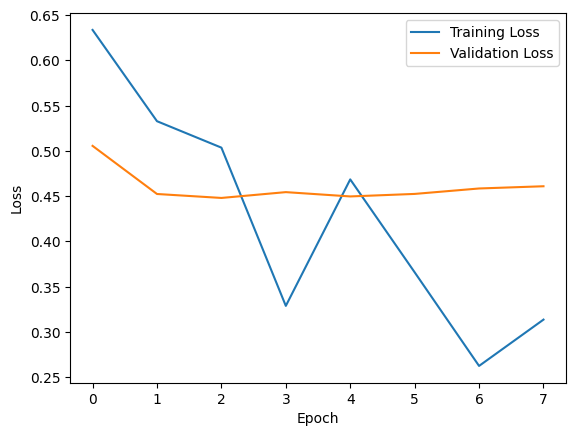

Accuracy: 0.7940
Message: તમે $1,000નું ગિફ્ટ કાર્ડ જીત્યું છે! તમારા ઇનામનો દાવો કરવા માટે અહીં ક્લિક કરો.
Predicted result: scam

Message: અભિનંદન! તમને મફત ક્રુઝ માટે પસંદ કરવામાં આવ્યા છે. તમારી સફર બુક કરવા માટે હમણાં જ કૉલ કરો.
Predicted result: scam

Message: તમારા એકાઉન્ટ સાથે ચેડા કરવામાં આવ્યા છે. તમારા એકાઉન્ટને સુરક્ષિત કરવા માટે કૃપા કરીને આ લિંક પર ક્લિક કરો.
Predicted result: scam

Message: કૃપા કરીને તમારી આગામી મીટિંગ માટે સમય શેડ્યૂલ કરો.
Predicted result: scam

Message: મારા દાદાને તેમના જન્મદિવસ પર આશીર્વાદ આપવા માટે આપનું આભાર.
Predicted result: ham

Message: आपको $1,000 गिफ्ट कार्ड मिला है! पुरस्कार प्राप्त करने के लिए यहां क्लिक करें।
Predicted result: scam

Message: बधाई हो! आपको एक मुफ्त क्रूज के लिए चुना गया है। अपनी यात्रा बुक करने के लिए अभी कॉल करें।
Predicted result: scam

Message: आपका खाता सुरक्षित नहीं है। कृपया अपने खाते को सुरक्षित करने के लिए इस लिंक पर क्लिक करें।
Predicted result: ham

Message: कृपया अपने अगले मीटिंग के लिए समय निर्धारित करें।
Pred

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam7.csv', encoding='utf-8')

# Preprocess text data
data['v2'].fillna('', inplace=True)
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = TfidfVectorizer(max_features=5000)  # Using TF-IDF
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define the RNN model
class SMSRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SMSRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # RNN forward pass
        out, _ = self.rnn(x, h0)

        # Get the last output
        out = out[:, -1, :]

        # Fully connected layer
        out = self.dropout(out)
        out = torch.sigmoid(self.fc(out))
        return out

input_size = X_train_vectorized.shape[1]
hidden_size = 128
num_layers = 2
model = SMSRNN(input_size, hidden_size, num_layers)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adjusted learning rate

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 50
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)  # Add a sequence dimension
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_inputs = X_test_tensor.unsqueeze(1)  # Add a sequence dimension
        val_outputs = model(val_inputs).squeeze()
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    val_inputs = X_test_tensor.unsqueeze(1)  # Add a sequence dimension
    outputs = model(val_inputs).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

# Prediction functions
def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32).unsqueeze(1)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results

# Example new messages for testing

new_messages = [

    # Gujarati Scam Messages
    "તમે $1,000નું ગિફ્ટ કાર્ડ જીત્યું છે! તમારા ઇનામનો દાવો કરવા માટે અહીં ક્લિક કરો.",  # scam
    "અભિનંદન! તમને મફત ક્રુઝ માટે પસંદ કરવામાં આવ્યા છે. તમારી સફર બુક કરવા માટે હમણાં જ કૉલ કરો.",  # scam
    "તમારા એકાઉન્ટ સાથે ચેડા કરવામાં આવ્યા છે. તમારા એકાઉન્ટને સુરક્ષિત કરવા માટે કૃપા કરીને આ લિંક પર ક્લિક કરો.",  # scam

    # Gujarati Ham Messages
    "કૃપા કરીને તમારી આગામી મીટિંગ માટે સમય શેડ્યૂલ કરો.",  # ham
    "મારા દાદાને તેમના જન્મદિવસ પર આશીર્વાદ આપવા માટે આપનું આભાર.",  # ham

    # Hindi Scam Messages
    "आपको $1,000 गिफ्ट कार्ड मिला है! पुरस्कार प्राप्त करने के लिए यहां क्लिक करें।",  # scam
    "बधाई हो! आपको एक मुफ्त क्रूज के लिए चुना गया है। अपनी यात्रा बुक करने के लिए अभी कॉल करें।",  # scam
    "आपका खाता सुरक्षित नहीं है। कृपया अपने खाते को सुरक्षित करने के लिए इस लिंक पर क्लिक करें।",  # scam

    # Hindi Ham Messages
    "कृपया अपने अगले मीटिंग के लिए समय निर्धारित करें।",  # ham
    "मेरे दादा जी को उनके जन्मदिन पर आशीर्वाद देने के लिए आपका धन्यवाद।",  # ham

    # English Scam Messages
    "You've won a $1,000 gift card! Click here to claim your prize.",  # scam
    "Congratulations! You've been selected for a free cruise. Call now to book your trip.",  # scam
    "Your account has been compromised. Please click this link to secure your account.",  # scam

    # English Ham Messages
    "Please schedule your next meeting.",  # ham
    "Thank you for blessing my grandfather on his birthday.",

]

results = check_multiple_messages(model, new_messages, vectorizer)

# Print the results
for message, result in results:
    print(f'Message: {message}\nPredicted result: {result}\n')